In [1]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [2]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [3]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/BPagano-RtDriven'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [4]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

In [21]:
len(all_data)

77

In [ ]:
df2 = pd.concat(all_data)
df2.head(5)

In [23]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [ ]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

In [25]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(75, 7)

In [26]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
#df_weekly

In [27]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
mask = (df_weekly['Date'] <= '2022-03-02')
df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
0,2020-10-24,2020-10-18,1 wk ahead inc case,42,point,NaN,9411.91021,1344.558601
1,2020-10-31,2020-10-25,1 wk ahead inc case,42,point,NaN,12488.21006,1784.030009
2,2020-11-07,2020-11-01,1 wk ahead inc case,42,point,NaN,12774.00000,1824.857143
3,2020-11-14,2020-11-08,1 wk ahead inc case,42,point,NaN,22859.40000,3265.628571
4,2020-11-21,2020-11-15,1 wk ahead inc case,42,point,NaN,43729.40000,6247.057143


In [28]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[1344.5586014285714, 1344.5586014285714, 1344.5586014285714, 1344.5586014285714, 1344.5586014285714, 1344.5586014285714, 1344.5586014285714, 1784.0300085714284, 1784.0300085714284, 1784.0300085714284, 1784.0300085714284, 1784.0300085714284, 1784.0300085714284, 1784.0300085714284, 1824.857142857143, 1824.857142857143, 1824.857142857143, 1824.857142857143, 1824.857142857143, 1824.857142857143, 1824.857142857143, 3265.628571428572, 3265.628571428572, 3265.628571428572, 3265.628571428572, 3265.628571428572, 3265.628571428572, 3265.628571428572, 6247.057142857143, 6247.057142857143, 6247.057142857143, 6247.057142857143, 6247.057142857143, 6247.057142857143, 6247.057142857143, 9321.028571428571, 9321.028571428571, 9321.028571428571, 9321.028571428571, 9321.028571428571, 9321.028571428571, 9321.028571428571, 8774.266428571429, 8774.266428571429, 8774.266428571429, 8774.266428571429, 8774.266428571429, 8774.266428571429, 8774.266428571429, 10469.1, 10469.1, 10469.1, 10469.1, 10469.1, 10469.1, 

In [29]:
len(predictions)

495

In [30]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2020-10-24') & (df1['Date'] <= '2022-03-04')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2020-10-24,3500,3554.6,399204,25603978,882.8,933.0,74512.9,2860489,-5275.682283,2774.207671
1,2020-10-25,3336,3679.2,402540,25603978,716.1,937.8,75229.2,2860489,-5275.682283,2774.207671
2,2020-10-26,4734,3915.1,407274,25603978,1360.9,1031.6,76591.0,2860489,-5275.682283,2774.207671
3,2020-10-27,4556,4133.4,411830,25603978,1153.3,1078.6,77743.5,2860489,-5275.682283,2774.207671
4,2020-10-28,4812,4229.0,416642,25603978,1236.9,1093.9,78980.7,2860489,-5275.682283,2774.207671


In [31]:
len(df1_copy)

495

In [32]:
# assigning predictions list to the actual dataframe
df1_copy['Prediction'] = predictions

In [ ]:
df1_copy.head(20)

In [34]:
# renaming the dataframe for graphing
merged_df_new = df1_copy

In [35]:
merged_df_new.shape

(495, 12)

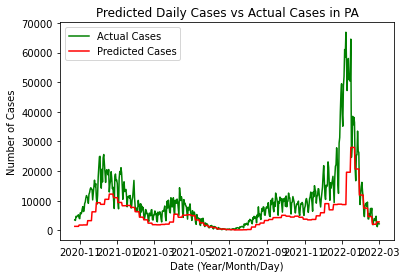

In [36]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['Actual'] - row["Prediction"]) / row['Actual'])
  error.append((abs(row['Actual'] - row["Prediction"])) / row['Actual'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

In [ ]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

In [ ]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

In [ ]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

In [ ]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  =0   changed from 7 to 6 so its not 0

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [ ]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

In [ ]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [ ]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

In [ ]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#Plot with combined daily accuracy and running weekly accuracy

#Daily Accuracy
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Running Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='b', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [ ]:
#Calculate Monthly Accuracy Averages
#We are going to use an average of 30 days per month for these calculations

monthlyAccuracy = 0
averageMonthlyAccuracy = []
amountOfMonths = int(length / 30)
remainderDays = length % 30

i = 0
while i < length:
  monthlyAccuracy += accuracy[i]
  if (i + 1) % 30 == 0 and amountOfMonths > 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / 30)
    amountOfMonths -= 1
    monthlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfMonths == 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / remainderDays)
    monthlyAccuracy = 0
  i += 1

weeklyDateListForMonths = []
i = 0
weeklyDateListForMonths.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 30 == 0:
    weeklyDateListForMonths.append(merged_df_new['Date'][i])
  i += 1


In [ ]:
len(averageMonthlyAccuracy)

In [ ]:
#Create Dataframe for Monthly Accuracy
i = 0
data = []
while i < len(averageMonthlyAccuracy):
  data.append([weeklyDateListForMonths[i], averageMonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Month Of', 'Average Monthly Accuracy'])